In [3]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel
True
from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

## setup dataloader

In [4]:
#conf = OmegaConf.load("../../configs/osmencoder-abs-logrsme-1epoch.yaml")
conf = OmegaConf.load("../../configs/osmencoder-x.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-17 04:00:13.424 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:876 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-17 04:00:16.538 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:880 - read train split with 60295 chip files (out of 60396)
2024-04-17 04:00:16.538 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:885 - max cache size is -1
2024-04-17 04:00:17.241 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:876 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-17 04:00:17.872 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:880 - read val split with 12288 chip files (out of 12304)
2024-04-17 04:00:17.872 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:885 - max cache size is -1
2024-04-17 04:

## setup model and optimizer

In [99]:
conf = OmegaConf.load("../../configs/osmencoder-x.yaml")

eps = 1e-5
def rmsloge(a,b):
    eps = 1e-5
    alog = torch.sign(a)*torch.log(torch.abs(a) + 1e-5)
    blog = torch.sign(b)*torch.log(torch.abs(b) + 1e-5)
    return torch.sqrt(torch.mean( (alog - blog)**2 ))



loss_funcs = {
    'rmsloge': rmsloge,
    'msloge': lambda a,b: torch.sqrt(rmsloge(a,b)),
    'rmse': lambda a,b: torch.sqrt(torch.mean( (a - b)**2 )),
    'relrmse': lambda a,b: torch.sqrt(torch.mean( ((a - b)/a)**2 )),
    'rwmse': lambda a,b: torch.sqrt(torch.mean( 1/(torch.abs(a)**2+eps) * (a - b)**2 )),
    'mse': lambda a,b: torch.mean( (a - b)**2 ),
    'mstanhe': lambda a,b: torch.mean( (torch.tanh(a) - torch.tanh(b))**2 )
    
}

dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
#optimizer = torch.optim.RMSprop(m.parameters(), lr=1e-5)

loss_fn = loss_funcs[conf.training.loss]

dl.disable_chip_loading()

sum([np.product(p.shape) for p in m.parameters()]), conf.training.epochs

(5662464, 1)

In [100]:
m.layers

Sequential(
  (0): Linear(in_features=297, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=2048, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=768, bias=True)
)

In [101]:
conf.training.loss

'rmse'

In [102]:
dl.disable_chip_loading()
dltrain = dl.train_dataloader()


## train loop

In [104]:
n_epochs = conf.training.epochs
n_epochs = 1

lossh = []
rmseh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = torch.cat([batch['osm_ohecount'], batch['osm_ohearea'], batch['osm_ohelength']], axis=1).type(torch.float)
        t = batch['embedding']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss_base = loss_fn(t,o)
        rmse = loss_funcs['rmse'](t,o)        
        
        #loss_variance = torch.sqrt(torch.mean((t.std(axis=0) - o.std(axis=0))**2))
        output_stdev = (o.std(axis=0)+1e-5).mean()
        loss = loss_base 
        
        # backpropage and sigmoidupdate
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        rmsen = rmse.detach().cpu().numpy()
        lossh.append(lossn)
        rmseh.append(rmsen)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-500:])
        rmsem = np.mean(rmseh[-500:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} rmse {rmsem:.5f} params {psummary:.7f} output_stdev {output_stdev.detach().numpy():.5f}", end="\r")
        #if loss < 0.5:
        #    print ("low loss!!")
        #    break
    #print()

In [ ]:
np.

In [ ]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(500).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
for ax,i in subplots(2, usizex=10):
    if i==0: ploth(np.r_[rmseh], name='rmse', ax=ax)#, ylim=(-.01,15))
    if i==1: ploth(lossh, name='loss', ax=ax, ylim=(-0.01,0.1))

## visualize targets vs predictions on random chips

In [79]:
dl.enable_chip_loading()

In [80]:
b = next(iter(dl.train_dataloader()))
b.keys()

dict_keys(['multilabel', 'chip', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

In [81]:
len(b['chip'])

16

In [82]:
tr_targets = b['embedding'].numpy()
x = torch.cat([b['osm_ohecount'], b['osm_ohearea'], b['osm_ohelength']], axis=1).type(torch.float)
tr_predictions = m(x).detach().numpy()

In [83]:
def plot_chip(batch, idx):
    b = batch
    c = b['chip'][idx][:3].detach().numpy()
    c = np.transpose(c, [1,2,0]).astype(float)
    _,vmax = np.percentile(c, [5,99])
    c /= vmax
    c[c>1]=1
    plt.axis('off')
    plt.imshow(c)

    n_osmobjects = b['osm_ohecount'][idx].numpy().sum()
    total_osmarea = b['osm_ohearea'][idx].numpy().sum()
    total_osmlength = b['osm_ohelength'][idx].numpy().sum()

    plt.title(f"chip {idx}\nosm count {n_osmobjects}\nosm area {total_osmarea:.2f}\nosm length {total_osmlength:.2f}")

In [84]:
conf.training.loss

'rmse'

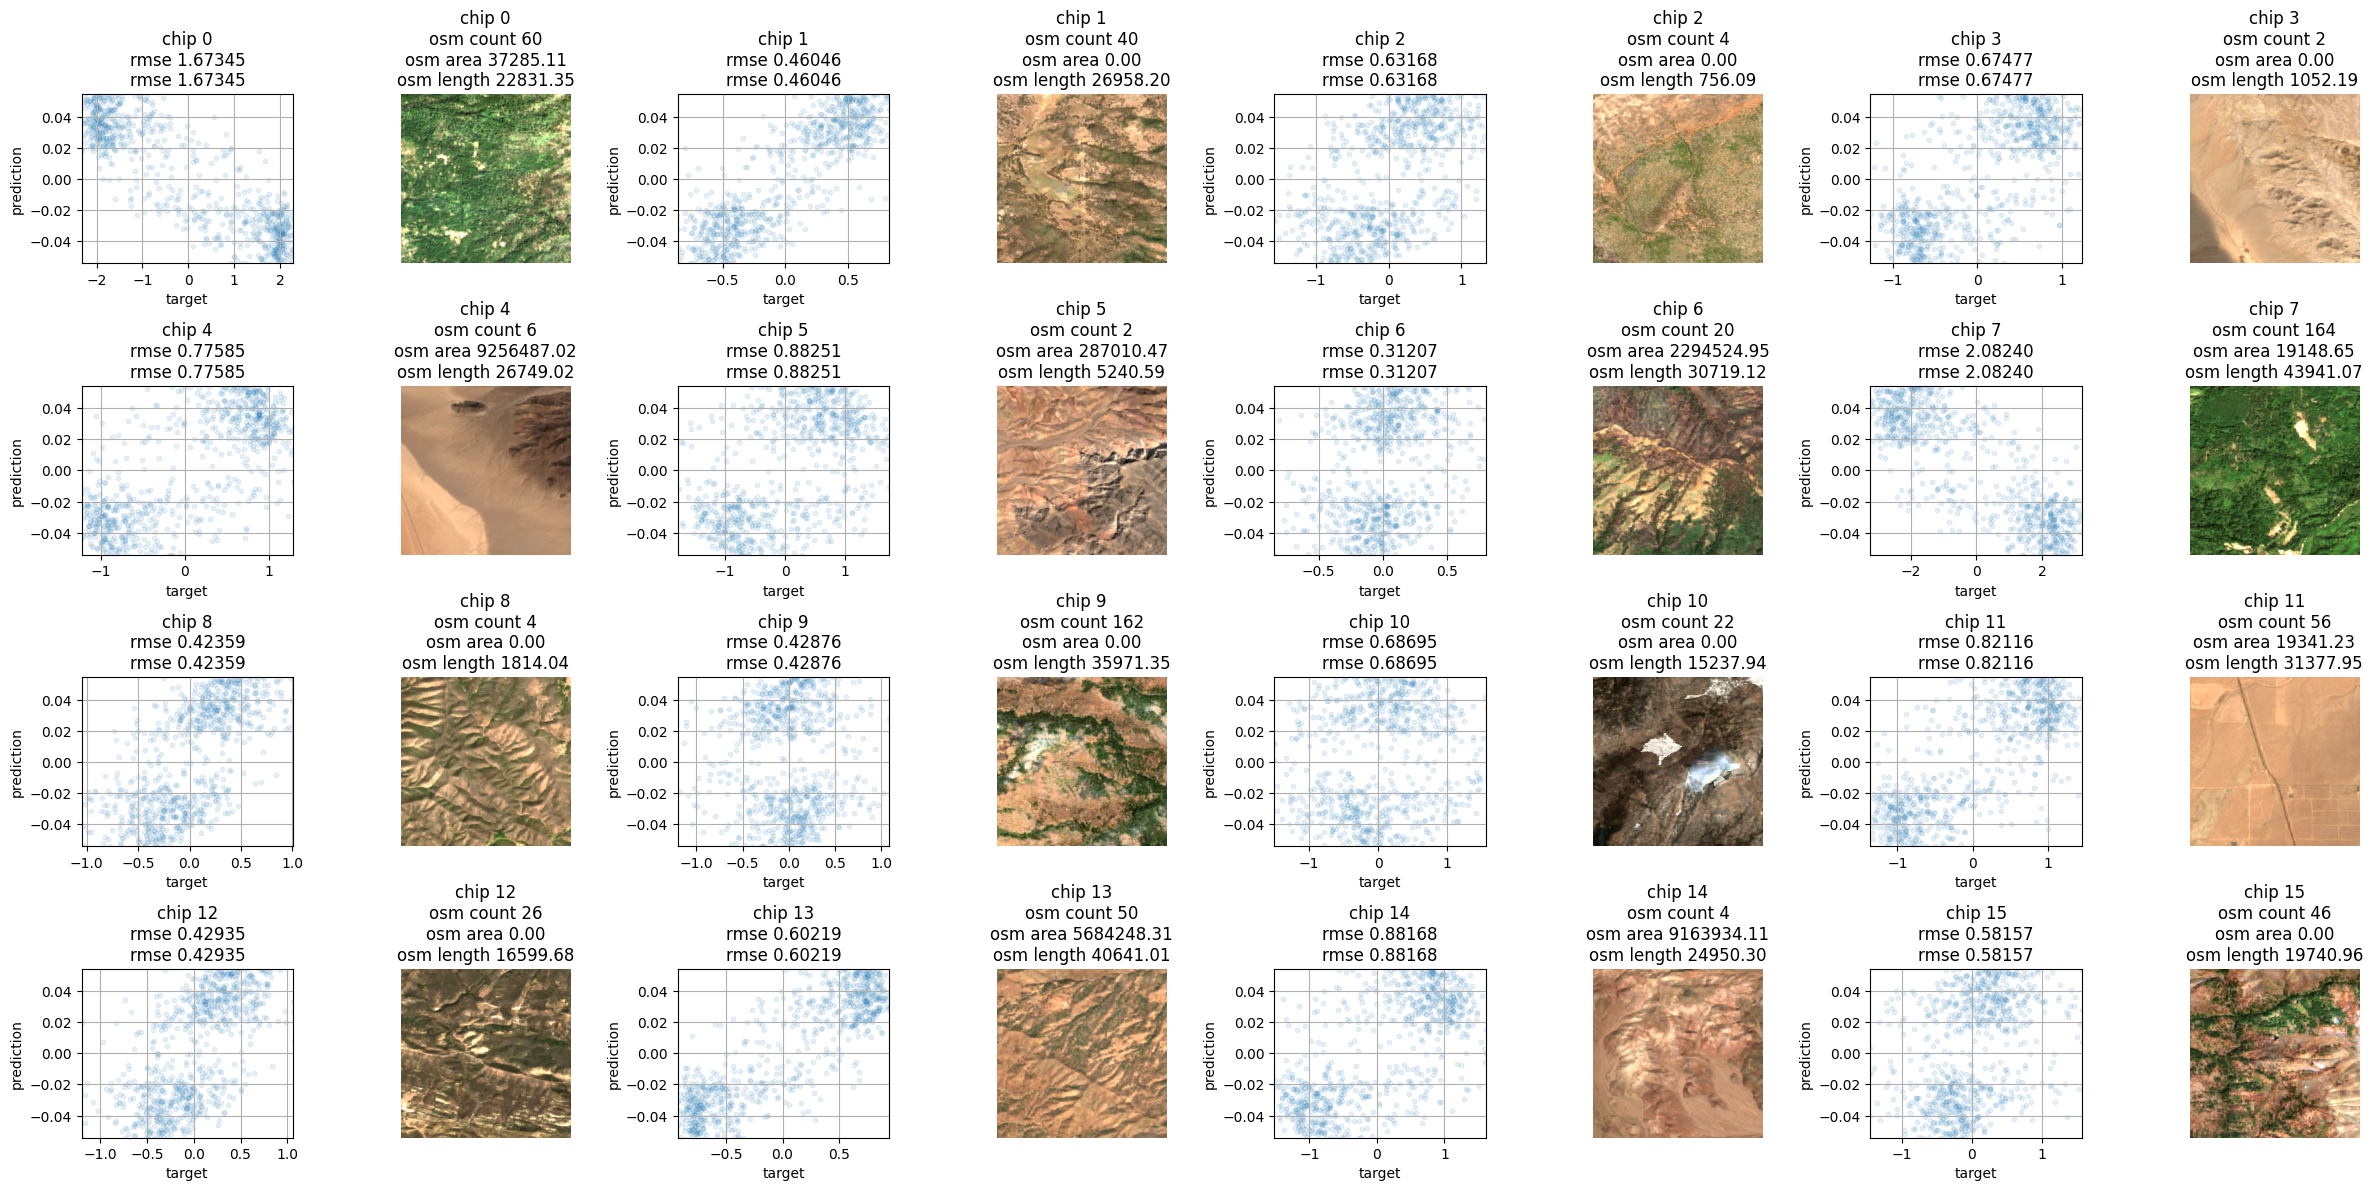

In [85]:
for ax,i in subplots(len(tr_targets)*2, n_cols=8):
    idx = i//2
    t = tr_targets[idx]
    p = tr_predictions[idx]
    if i%2==0:
        plt.scatter(t, p, alpha=.1, s=10)
        plt.grid()
        plt.xlabel("target")
        plt.ylabel("prediction")
        rmse = np.sqrt(np.mean ( (t-p)**2 ))
        logr = loss_funcs[conf.training.loss](torch.tensor(t),torch.tensor(p))
        plt.title(f"chip {idx}\nrmse {rmse:.5f}\n{conf.training.loss} {logr:.5f}")
        ta,tb = np.percentile(t, [1,99])
        pa,pb = np.percentile(p, [1,99])
        plt.xlim(ta, tb)
        plt.ylim(pa, pb)
    else:
        plot_chip(b, idx)


## measure loss on full train,val,test datasets

In [86]:
def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    for batch in pbar(dataloader):
        x = torch.cat([batch['osm_ohecount'], batch['osm_ohearea'], batch['osm_ohelength']], axis=1).type(torch.float)
        t = batch['embedding']
    
        o = m(x)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)
        
    targets = np.r_[targets]
    predictions = np.r_[predictions]
    return targets, predictions

In [87]:
dl.disable_chip_loading()
tr_targets, tr_predictions = get_targets_and_predictions(dl.train_dataloader())

 30% (1167 of 3769) |######              | Elapsed Time: 0:00:09 ETA:   0:00:20Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7274ecc5c0e0>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100% (3769 of 3769) |####################| Elapsed Time: 0:00:27 Time:  0:00:270002


In [89]:
tr_predictions.mean(axis=0).sum()

1.266082

In [81]:
ts_targets, ts_predictions = get_targets_and_predictions(dl.test_dataloader())
val_targets, val_predictions = get_tarsigmoidgets_and_predictions(dl.val_dataloader())

100% (839 of 839) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000
100% (768 of 768) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000


In [90]:
from earthtext.datamodules.components import chipmultilabel
chipmultilabel.embeddings_mean.sum(), tr_targets.std().sum()

(-2.25184824947902, 1.0000035553330475)

In [91]:
regr_to_mean_tr = tr_targets.mean(axis=0)

In [92]:
# performance of predicting with the mean
for k,v in loss_funcs.items():
    print (f"{k:10s}", f"{v(torch.tensor(tr_targets), torch.tensor(regr_to_mean_tr)):.5f}")

rmsloge    10.80422
msloge     3.28698
rmse       1.00000
relrmse    15.71509
rwmse      0.99818
mse        1.00001
mstanhe    0.36260


In [21]:
{'train_loss': np.sqrt(np.mean( (tr_predictions-tr_targets)**2 )),
 'test_loss': np.sqrt(np.mean( (ts_predictions-ts_targets)**2 )),
 'val_loss': np.sqrt(np.mean( (val_predictions-val_targets)**2 ))
}

NameError: name 'ts_predictions' is not defined

## targets vs other targets 

In [93]:
def plot_target_pairs(targets):
    for ax,i in subplots(len(targets)//2 * 3, n_cols=9):
        idx1 = i//3
        idx2 = len(targets)//2+i//3
    
        if i%3==0:
            t1 = targets[idx1]
            t2 = targets[idx2]
            a1,b1 = np.percentile(t1, [1,99])
            a2,b2 = np.percentile(t2, [1,99])
            plt.scatter(t1, t2, alpha=.2)
            plt.xlim(a1,b1)
            plt.ylim(a2,b2)
            plt.grid()
            plt.xlabel(f"clayv2 embeddings for chip {idx1}")
            plt.ylabel(f"clayv2 embeddings for chip {idx2}")
        elif i%3==1:
            plot_chip(b, idx1)
        else:
            plot_chip(b, idx2)

In [94]:
from earthtext.datamodules.components import chipmultilabel

In [95]:
dl.enable_chip_loading()
traindl = dl.train_dataloader()
traindl.dataset.substract_embeddings_mean = False
b = next(iter(traindl))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7274ecc5c0e0>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


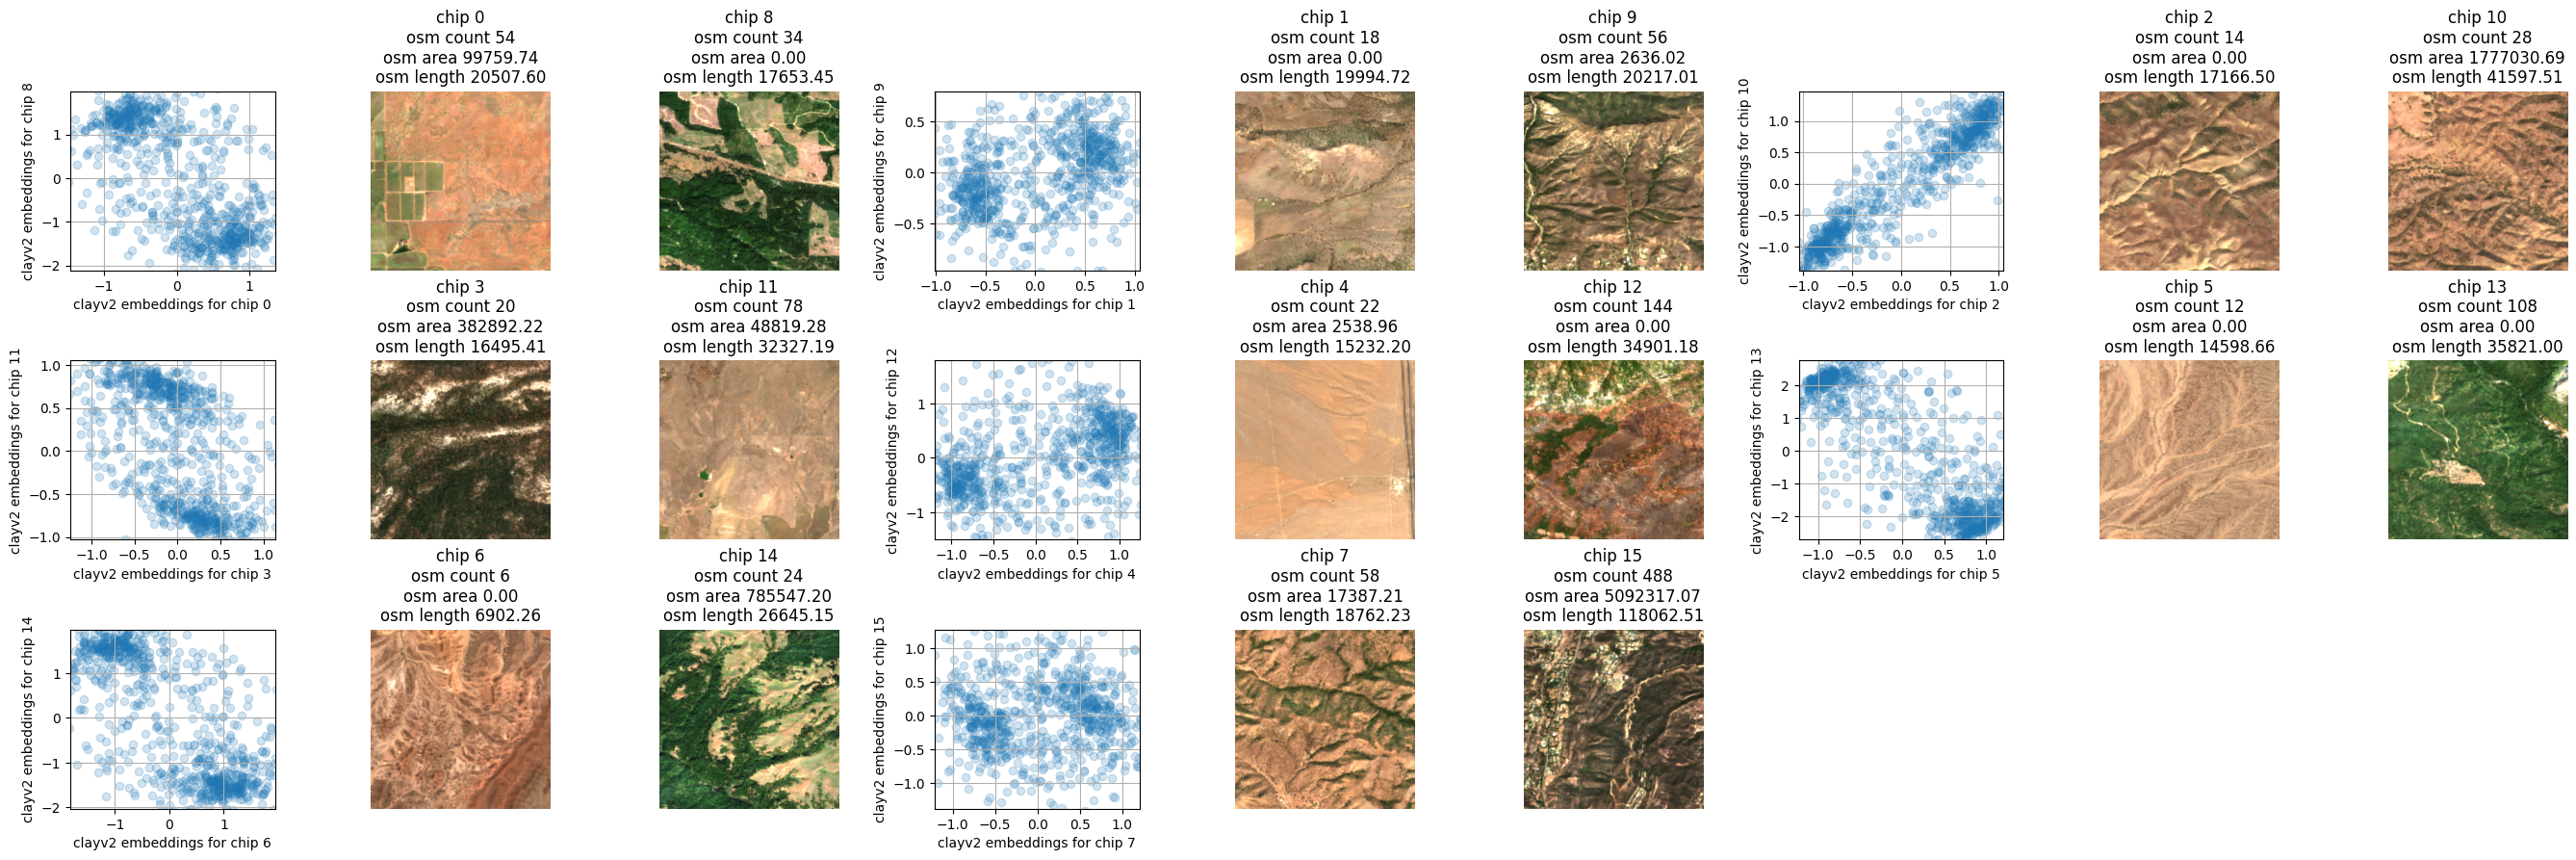

In [96]:
tr_targets = b['embedding'].numpy() 

plot_target_pairs(tr_targets)

In [97]:
embeddings_mean = chipmultilabel.embeddings_mean
def signed_meanembedding_substraction(t):
    return torch.sign(t) * torch.abs(t - embeddings_mean)    

NameError: name 'norm_embeddings' is not defined

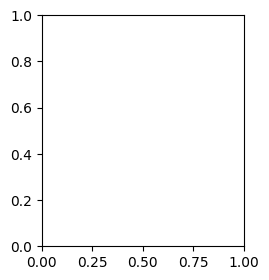

In [98]:
for ax,i in subplots(4):
    t = b['embedding'].numpy() 
    #tm = b['embedding'].numpy() - chipmultilabel.embeddings_mean
    tm = norm_embeddings(b['embedding']).numpy()
    i1, i2 = 1,9
    if i==0: 
        plt.scatter(t[i1], t[i2], alpha=.5, s=10)
        plt.title(f"chips {i1} vs {i2}\n original embeddings")
    if i==1: 
        plt.scatter(tm[i1], tm[i2], alpha=.5, s=10)
        plt.title(f"chips {i1} vs {i2}\nmean substracted embeddings")
    if i==2:
        plt.scatter(t[i1], tm[i1], alpha=.5, s=10)
        plt.title(f"chip {i1} original vs substracted")
        plt.xlim(-0.02, 0.02); plt.ylim(-0.02, 0.02)
    if i==3:
        plt.scatter(t[i2], tm[i2], alpha=.5, s=10)
        plt.title(f"chip {i2} original vs substracted")
        plt.xlim(-0.02, 0.02); plt.ylim(-0.02, 0.02)
    
    plt.grid();
    

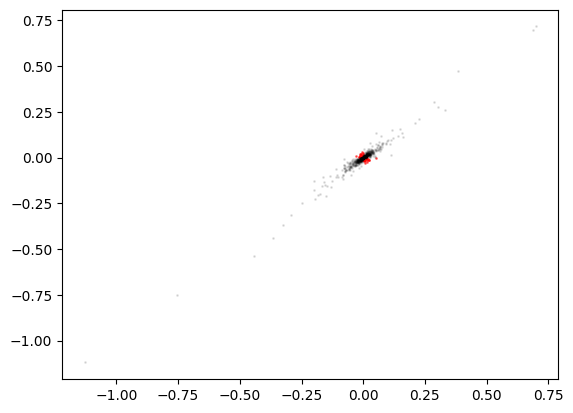

In [47]:
idxs = np.sign(t[i1]) != np.sign(t[i2])
plt.scatter(t[i1][idxs], t[i2][idxs], alpha=.5, s=1, color='red')
plt.scatter(t[i1][~idxs], t[i2][~idxs], alpha=.1, s=1, color='black')



In [37]:
(np.sign(t[i1]) == np.sign(tm[i1]) ).mean(), (np.sign(t[i2]) == np.sign(tm[i2]) ).mean()

(1.0, 1.0)

In [38]:
(np.sign(t[i1]) == np.sign(t[i2]) ).mean(), (np.sign(tm[i1]) == np.sign(tm[i2]) ).mean()

(0.87890625, 0.87890625)

(-1.0, 100.0)

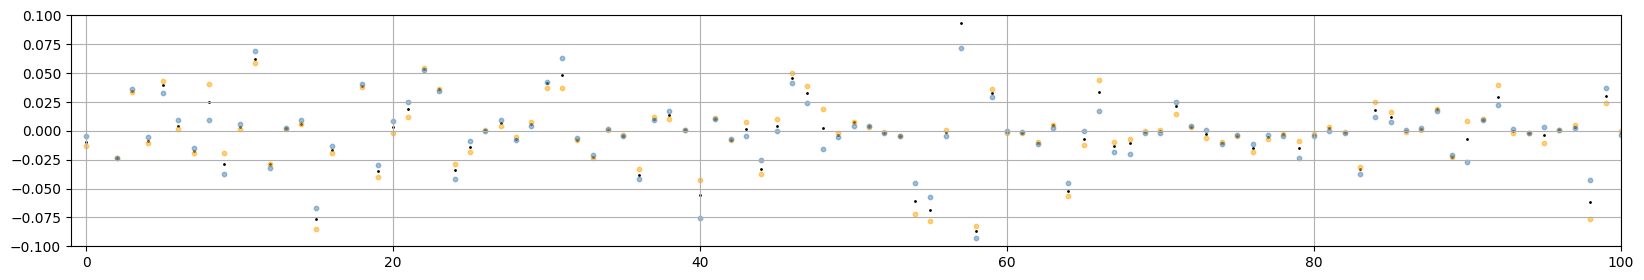

In [33]:
n = len(chipmultilabel.embeddings_mean)
plt.figure(figsize=(20,3))
plt.scatter(range(n), chipmultilabel.embeddings_mean, s=1, c='black')
plt.scatter(range(n), t[i1], alpha=.5, s=10, c='orange')
plt.scatter(range(n), t[i2], alpha=.5, s=10, c='steelblue')
plt.grid();
plt.ylim(-0.1, 0.1)
plt.xlim(-1,100)

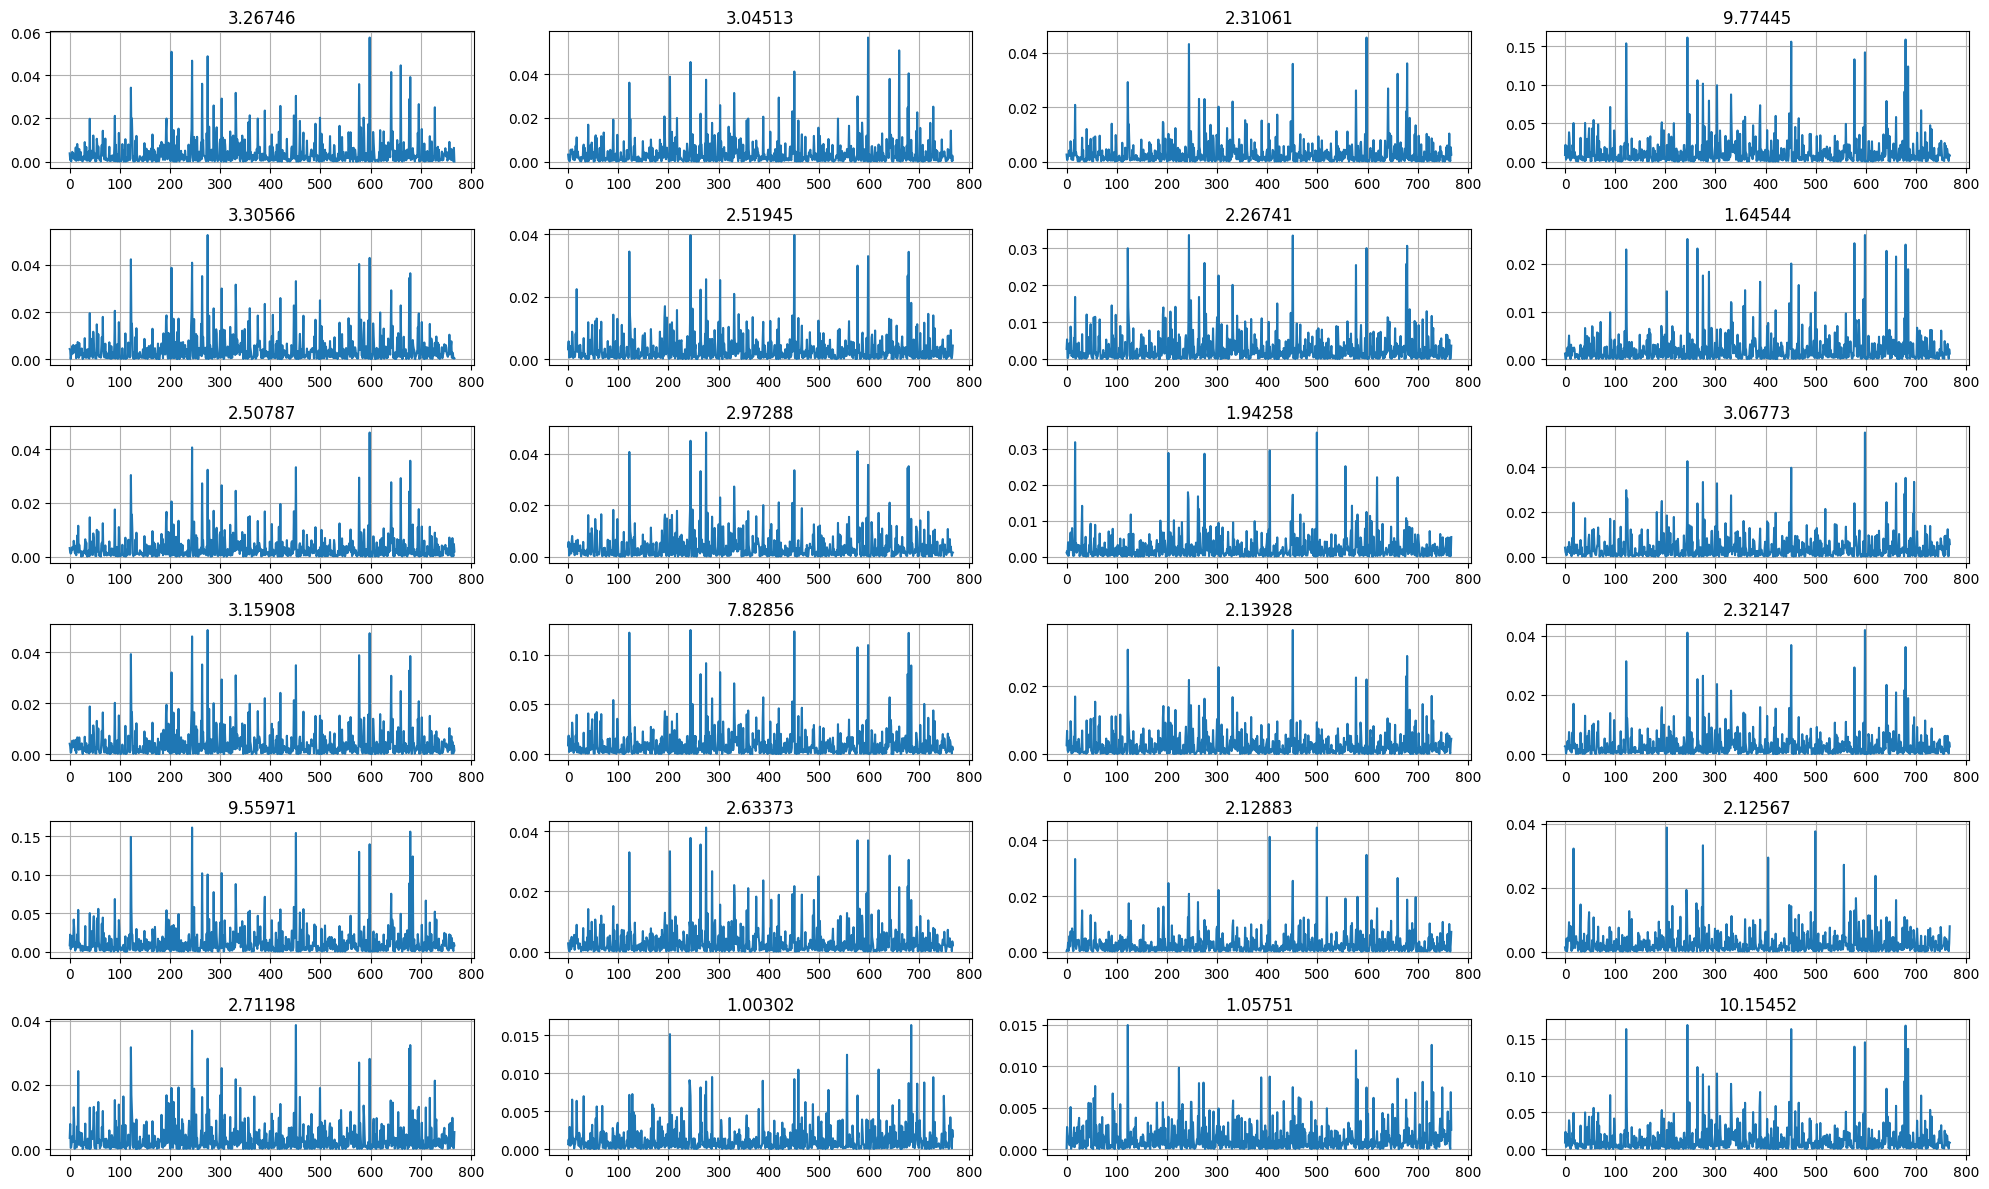

In [27]:
for ax, i in subplots(len(idxs), usizex=5, usizey=2, n_cols=4):
    t = ztr_targets[idxs[i]]
    plt.plot(t)
    plt.grid()
    plt.title(f"{sum(t):.5f}")